### STEP 1: Loading the Fashion MNIST Data

In [1]:
# Importing the Fashion MNIST dataset from tensorflow
from tensorflow.keras.datasets.fashion_mnist import load_data

# Loading the training and test data
(X_train, Y_train), (x_test, y_test) = load_data()
 
# Printing the shape of the dataset
print('Train Data Shape:', X_train.shape, Y_train.shape)
print('Test Data Shape:', x_test.shape, y_test.shape)

/Users/shounak/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Train Data Shape: (60000, 28, 28) (60000,)
Test Data Shape: (10000, 28, 28) (10000,)


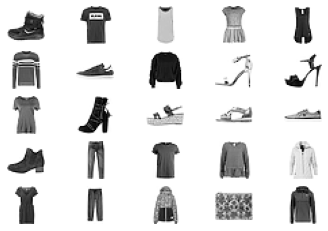

In [2]:
#Plotting a few images from the MNIST training dataset
 
from matplotlib import pyplot

for i in range(25):

  pyplot.subplot(5, 5, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(X_train[i], cmap='Greys')
pyplot.show()

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
 
from IPython import display

### STEP 2: Training the GAN Model

In [4]:
#Dividing the training data into features and labels
(train_img, train_label), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
train_img = train_img.reshape(train_img.shape[0], 28, 28, 1).astype('float32')
train_img = (train_img - 127.5) / 127.5  # Normalizing the images to [-1, 1]

In [6]:
#Defining the buffer and batch size
buff_size= 60000
batch_size = 64

In [7]:
# Batch and shuffle the data
train_data = tf.data.Dataset.from_tensor_slices(train_img).shuffle(buff_size).batch(batch_size)

In [8]:
# defining the generator model
def genG_model():
    modelG = tf.keras.Sequential()
    modelG.add(layers.Dense(7*7*256, use_bias=False, input_shape=(256,)))
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
    modelG.add(layers.Reshape((7, 7, 256)))
    assert modelG.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    modelG.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 7, 7, 128)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
   # upsample to 14x14
    modelG.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 14, 14, 64)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
    
    # upsample to 28x28
    modelG.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert modelG.output_shape == (None, 28, 28, 1)
 
    return modelG

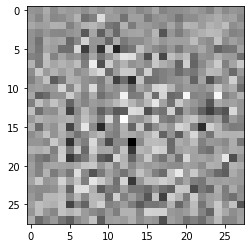

In [9]:
# sample image generated by the the generator
genG = genG_model()
 
noise = tf.random.normal([1, 256]) #latent space
generated_image = genG(noise, training=False)
 
plt.imshow(generated_image[0, :, :, 0], cmap='Greys')

In [10]:
# defining the discriminator model
def make_discriminator_model():
    modelD = tf.keras.Sequential()
    
    modelD.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1])) #2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    modelD.add(layers.Dense(1, activation='sigmoid'))

    return modelD

In [11]:
discriM = make_discriminator_model()
decision = discriM(generated_image)
print (decision)

tf.Tensor([[0.499875]], shape=(1, 1), dtype=float32)


In [12]:
# Computing loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriM_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def genG_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
genG_optimizer = tf.keras.optimizers.Adam(1e-4)
discriM_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
#defining the number of epochs to train for
EPOCHS = 40
noise_dim = 256
num_examples_to_generate = 16
 
# You will reuse this seed overtime (so it's easier to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
def trn_img(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = genG(noise, training=True)

      real_output = discriM(images, training=True)
      fake_output = discriM(generated_images, training=True)

      gen_loss = genG_loss(fake_output)
      disc_loss = discriM_loss(real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, genG.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, discriM.trainable_variables)

    genG_optimizer.apply_gradients(zip(grad_genG, genG.trainable_variables))
    discriM_optimizer.apply_gradients(zip(grad_discriM, discriM.trainable_variables))

### STEP 4&7: Saving the model without using checkpoints

In [18]:
def train(dataset, epochs):
  j = 0
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      trn_img(image_batch)
 
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    sv_img(genG,
                             epoch + 1,
                             seed)
 
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      discriM.save('CheckPoint/Dis%d'%j)
      genG.save('CheckPoint/Gen%d'%j)
      j = j+1
 
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # Generate after the final epoch
  display.clear_output(wait=True)
  sv_img(genG,
                           epochs,
                           seed)

### STEP 3: Displaying images

In [19]:
def sv_img(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
 
  fig = plt.figure(figsize=(4, 4))
 
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
 
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

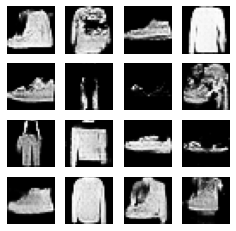

In [20]:
train(train_data, EPOCHS)

The main difficulties faced during display of images generated is the time and resource consumption. To generate even a few good results, large number of epochs need to be run otherwise the images generated are very poor.

### STEP 5&8: Loading the saved model weights

In [22]:
from tensorflow.keras.models import load_model

sgmodel = load_model('CheckPoint/Gen1')
sdmodel = load_model('CheckPoint/Dis1')
sgmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             3211264   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

### STEP 6: Re-training the model to generate better results

In [27]:
def trn_img_loaded(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = sgmodel(noise, training=True)

      real_output = sdmodel(images, training=True)
      fake_output = sdmodel(generated_images, training=True)

      gen_loss = genG_loss(fake_output)
      disc_loss = discriM_loss(real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, sgmodel.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, sdmodel.trainable_variables)

    genG_optimizer.apply_gradients(zip(grad_genG, sgmodel.trainable_variables))
    discriM_optimizer.apply_gradients(zip(grad_discriM, sdmodel.trainable_variables))

In [28]:
def train_load_img(dataset, epochs):
  j = 0
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      trn_img_loaded(image_batch)
 
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    sv_img(sgmodel, epoch + 1, seed)
 
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # Generate after the final epoch
  display.clear_output(wait=True)
  sv_img(sgmodel, epochs, seed)

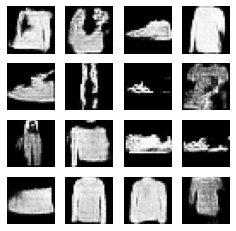

Time for epoch 3 is 2231.639859199524 sec


KeyboardInterrupt: 

In [29]:
train_load_img(train_data, 2)

Stopping the previous cell from running due to high number of epochs and time required. 